**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics


Bad key "text.kerning_factor" on line 4 in
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,-1,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=7, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 37.5 s, sys: 379 ms, total: 37.9 s
Wall time: 9.41 s
[0.2057584839709057, 0.24764249291232676, 0.9115189375533395, 0.8904787710472907, 0.8945031648540652]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [10]:
m.predict(X_valid)

array([9.23861, 9.25368, 9.19497, ..., 9.46933, 9.34289, 9.34289])

In [11]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.23 s, sys: 35.9 ms, total: 1.27 s
Wall time: 1.28 s


(9.238605103465453, 0.2635195935451169)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [12]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 123 ms, sys: 69.8 ms, total: 193 ms
Wall time: 474 ms


(9.238605103465453, 0.2635195935451169)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

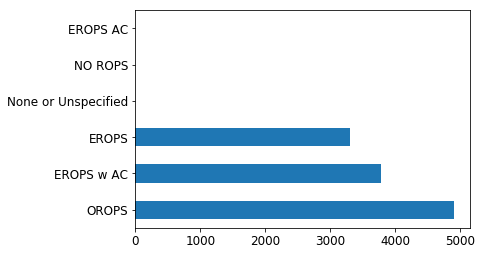

In [13]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [14]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.837505,0.269707
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.576117,0.265004
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.686735,0.219244


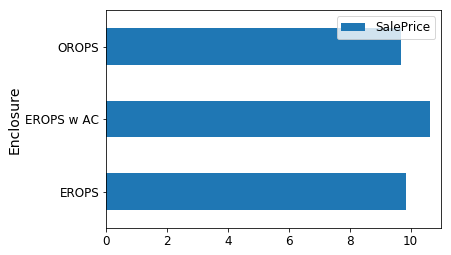

In [15]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

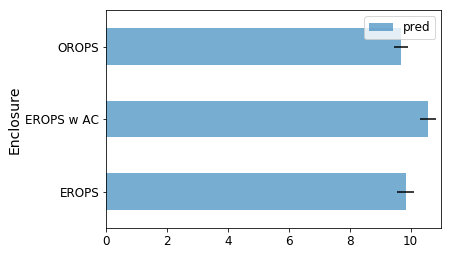

In [16]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

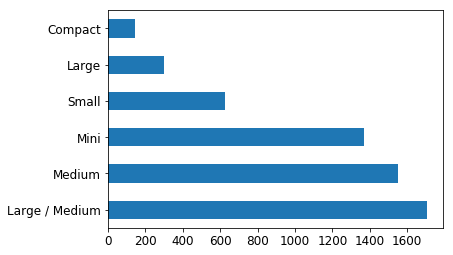

In [17]:
raw_valid.ProductSize.value_counts().plot.barh();

In [19]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.835085,0.336069
Large,10.470589,10.386829,0.360262
Large / Medium,10.691871,10.646435,0.291910
Medium,10.681511,10.619915,0.281400
Mini,9.535147,9.557271,0.249017
Small,10.324448,10.305768,0.318774


In [20]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.034685
Compact           0.034170
Small             0.030932
Large / Medium    0.027419
Medium            0.026497
Mini              0.026055
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [21]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.173682
37,Coupler_System,0.100713
13,ProductSize,0.096296
14,fiProductClassDesc,0.075880
2,ModelID,0.057055
39,Hydraulics_Flow,0.056385
63,saleElapsed,0.051528
10,fiSecondaryDesc,0.045201
38,Grouser_Tracks,0.044832
8,fiModelDesc,0.029089


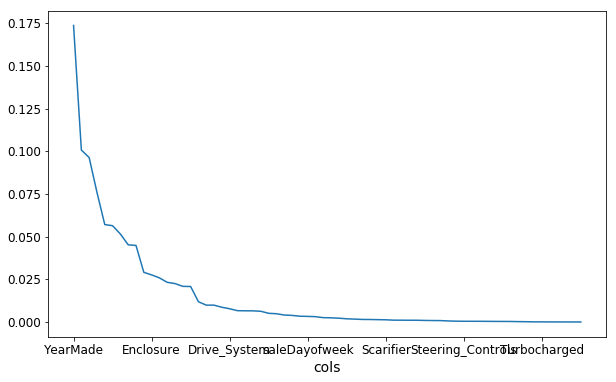

In [22]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [23]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

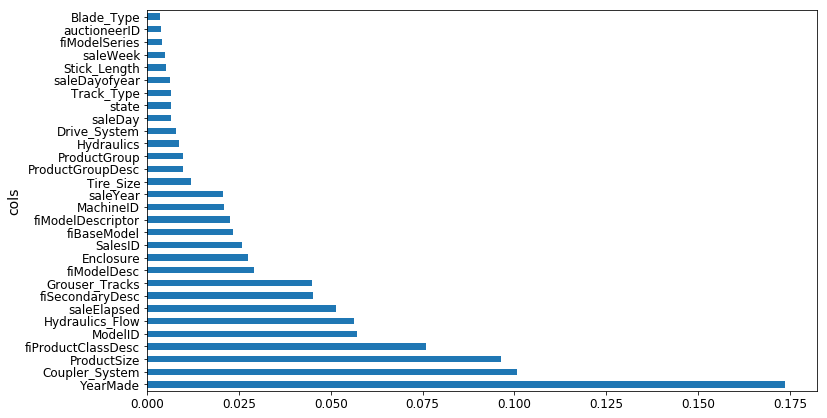

In [24]:
plot_fi(fi[:30]);

In [25]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

26

In [26]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [27]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=7, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20715260530365048, 0.24685867222544422, 0.9103158646496633, 0.8911709717160629, 0.8938447906181585]


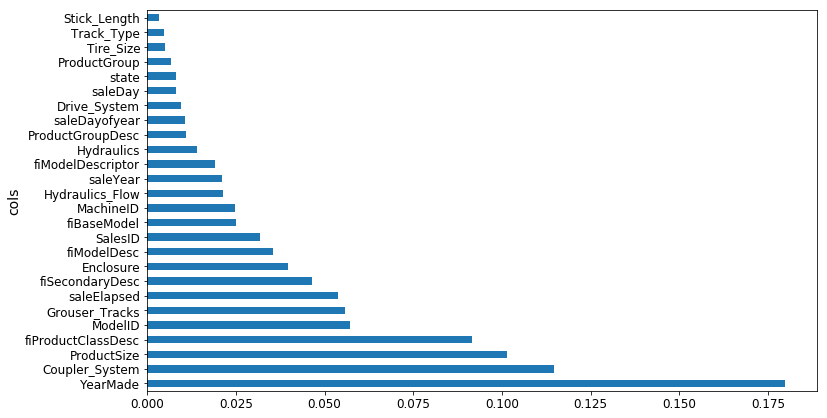

In [28]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [29]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=7, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20708483551435067, 0.2541120121599904, 0.910374535220199, 0.8846816647494619, 0.8926698797699489]


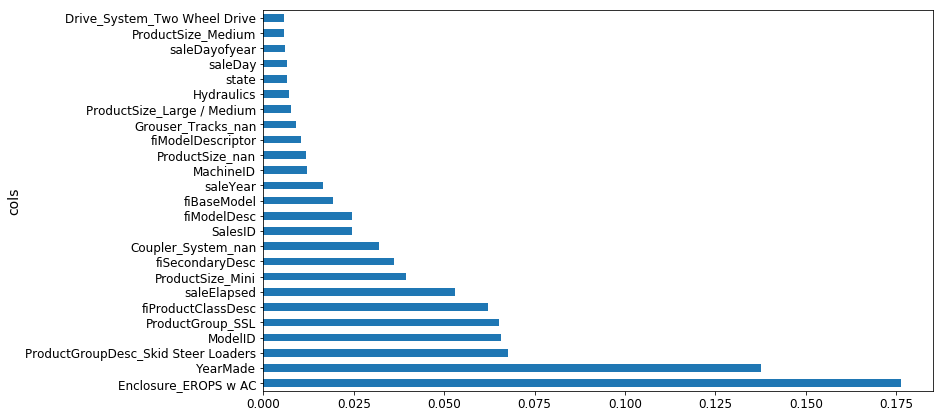

In [30]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [31]:
from scipy.cluster import hierarchy as hc

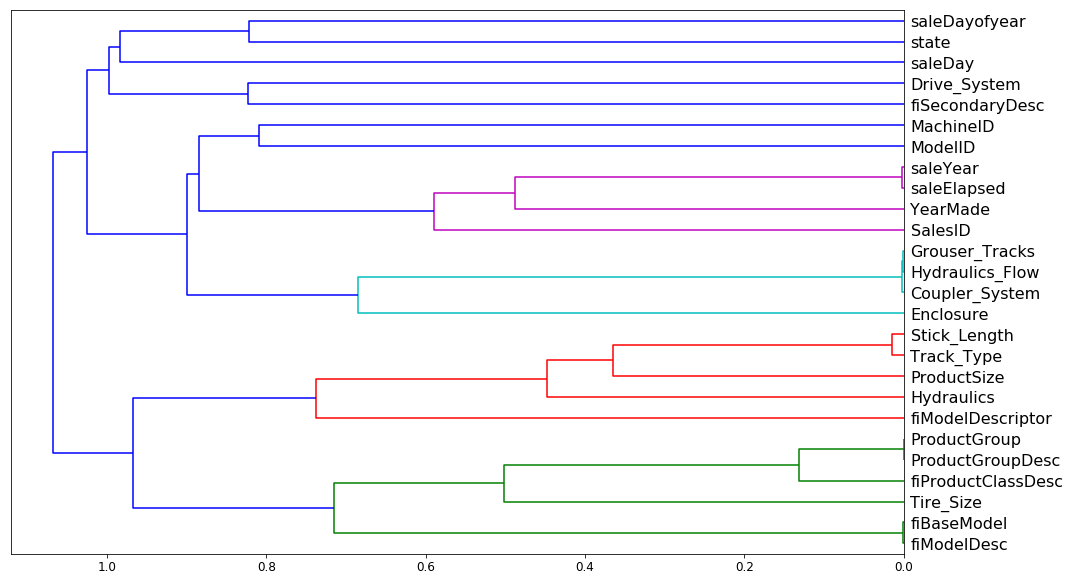

In [32]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [33]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=7, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [34]:
get_oob(df_keep)

0.8903781561028278

Now we try removing each variable one at a time.

In [35]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8898400914184043
saleElapsed 0.8871208196041266
fiModelDesc 0.8887811654852542
fiBaseModel 0.8889821957650744
Grouser_Tracks 0.8903418500302048
Coupler_System 0.8901014930906958


It looks like we can try one from each group for removal. Let's see what that does.

In [36]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8889012265845552

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [38]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

KeyError: "['saleYear' 'fiBaseModel' 'Grouser_Tracks'] not found in axis"

In [39]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [40]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

ValueError: Object arrays cannot be loaded when allow_pickle=False

And let's see how this model looks on the full dataset.

In [41]:
reset_rf_samples()

In [42]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=7, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1258817513354679, 0.2279424695207235, 0.9668822838938916, 0.9072105774155995, 0.9082267565413726]


# Partial dependence

In [43]:
from pdpbox import pdp
from plotnine import *

In [44]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [45]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=7)
m.fit(X_train, y_train);

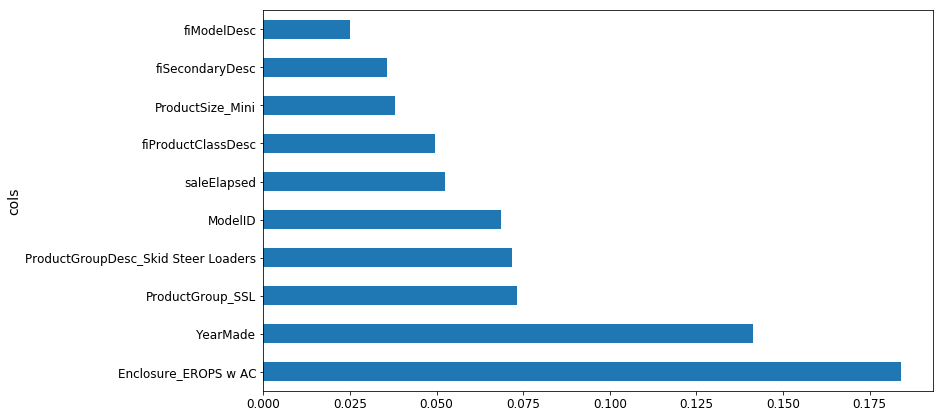

In [46]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

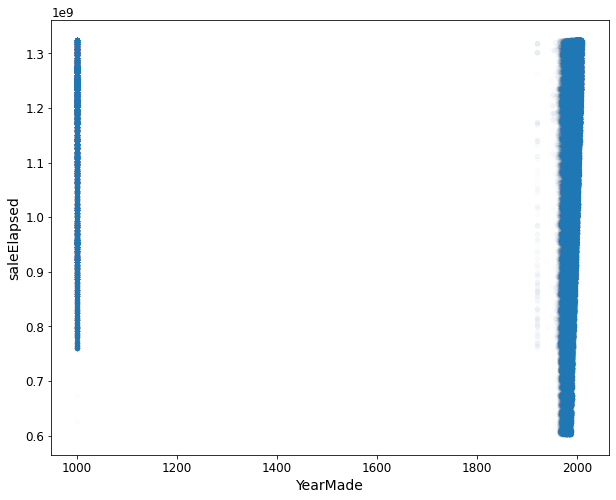

In [46]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [47]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

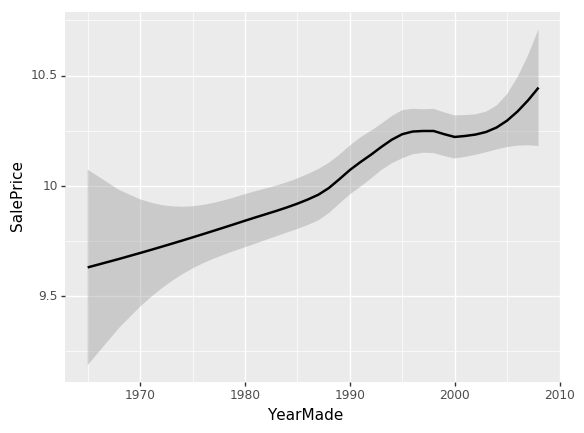

<ggplot: (8738101172744)>

In [48]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [49]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [51]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

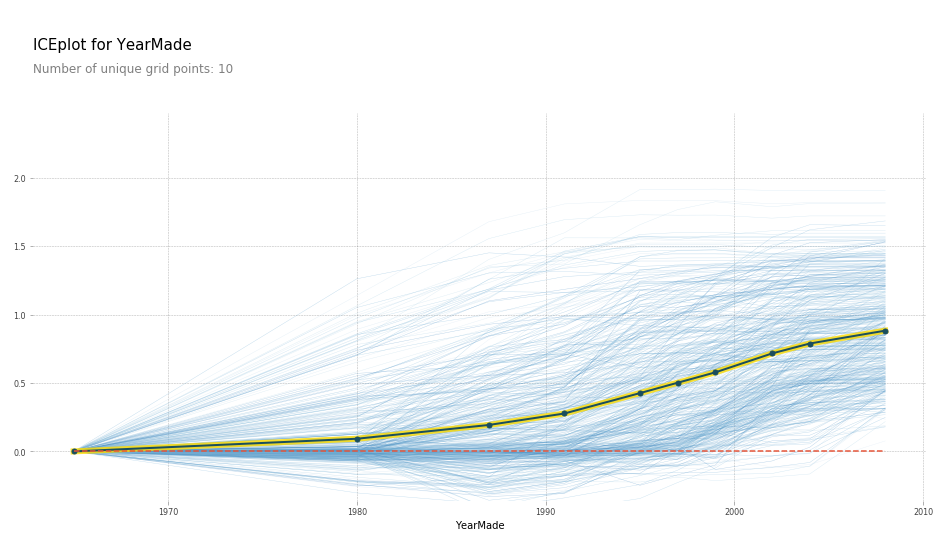

In [52]:
plot_pdp('YearMade')

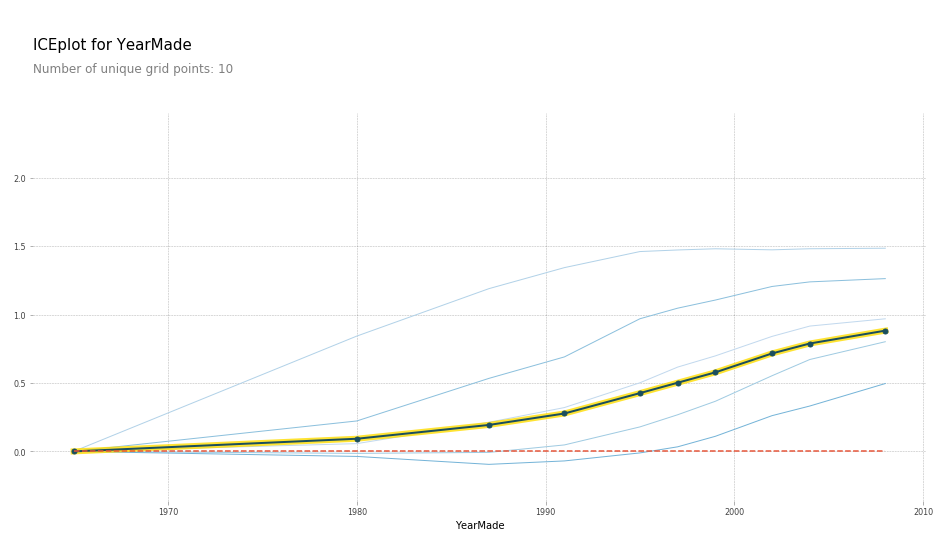

In [53]:
plot_pdp('YearMade', clusters=5)

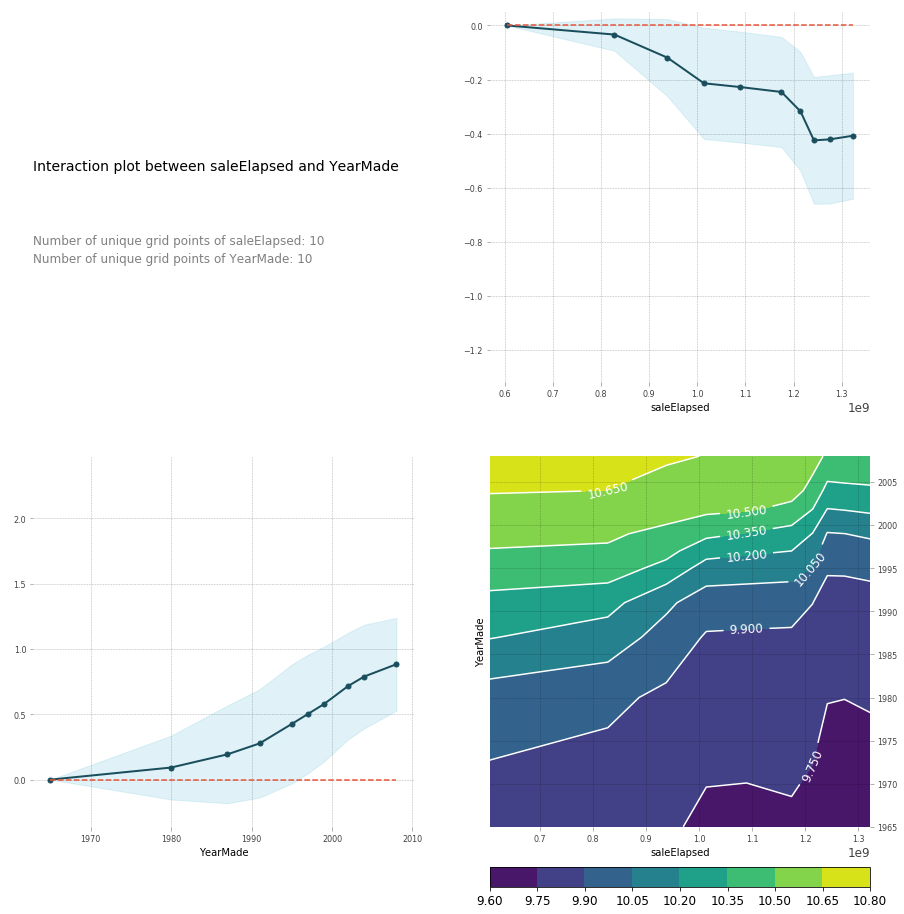

In [54]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

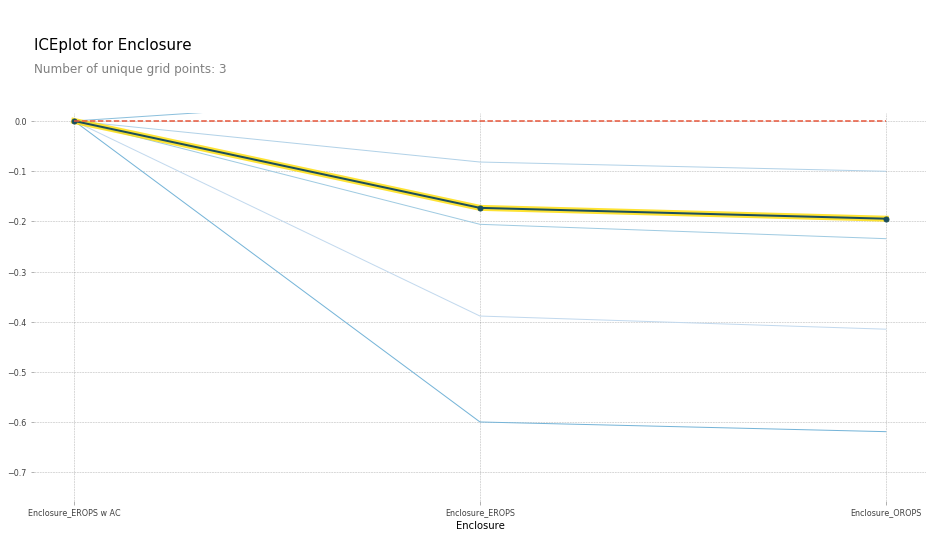

In [55]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [56]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

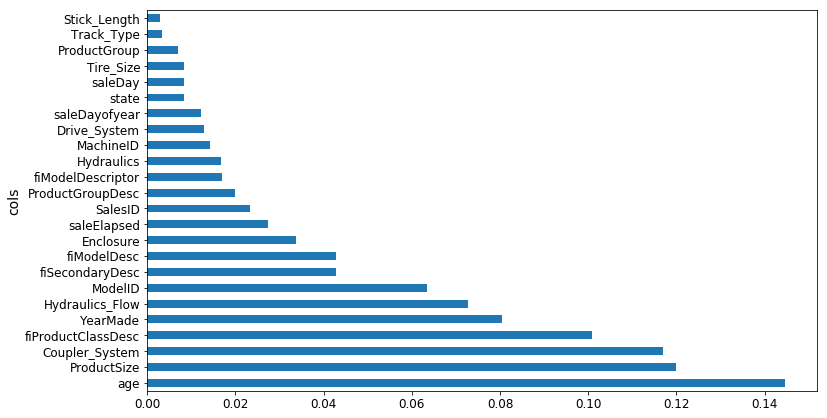

In [57]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [58]:
from treeinterpreter import treeinterpreter as ti

ModuleNotFoundError: No module named 'treeinterpreter'

In [ ]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [ ]:
row = X_valid.values[None,0]; row

array([[4364751, 2300944, 665, 172, 1.0, 1999, 3726.0, 3, 3232, 1111, 0, 63, 0, 5, 17, 35, 4, 4, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 19, 29, 3, 2, 1, 0, 0, 0, 0, 0, 2010, 9, 37,
        16, 3, 259, False, False, False, False, False, False, 7912, False, False]], dtype=object)

In [ ]:
prediction, bias, contributions = ti.predict(m, row)

In [ ]:
prediction[0], bias[0]

(9.1909688098736275, 10.10606580677884)

In [ ]:
idxs = np.argsort(contributions[0])

In [ ]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.54680742853695008),
 ('age', 11, -0.12507089451852943),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11143111128570773),
 ('fiModelDesc', 'KX1212', -0.065155113754146801),
 ('fiSecondaryDesc', nan, -0.055237427792181749),
 ('Enclosure', 'EROPS', -0.050467175593900217),
 ('fiModelDescriptor', nan, -0.042354676935508852),
 ('saleElapsed', 7912, -0.019642242073500914),
 ('saleDay', 16, -0.012812993479652724),
 ('Tire_Size', nan, -0.0029687660942271598),
 ('SalesID', 4364751, -0.0010443985823001434),
 ('saleDayofyear', 259, -0.00086540581130196688),
 ('Drive_System', nan, 0.0015385818526195915),
 ('Hydraulics', 'Standard', 0.0022411701338458821),
 ('state', 'Ohio', 0.0037587658190299409),
 ('ProductGroupDesc', 'Track Excavators', 0.0067688906745931197),
 ('ProductGroup', 'TEX', 0.014654732626326661),
 ('MachineID', 2300944, 0.015578052196894499),
 ('Hydraulics_Flow', nan, 0.028973749866174004),
 ('ModelID', 665, 0.0383074

In [ ]:
contributions[0].sum()

-0.7383536391949419

# Extrapolation

In [59]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [60]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999950140230601

In [61]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.791821
6,saleElapsed,0.159632
12,MachineID,0.040654
8,fiModelDesc,0.002286
0,YearMade,0.001411
4,ModelID,0.001326
21,saleDayofyear,0.001063
23,age,0.000669
7,fiSecondaryDesc,0.000606
1,Coupler_System,0.000214


In [62]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [63]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [64]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [65]:
x.drop(feats, axis=1, inplace=True)

In [66]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789292614521657

In [67]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
20,age,0.233653
0,YearMade,0.183438
18,saleDayofyear,0.162572
4,ModelID,0.075728
7,fiModelDesc,0.062758
16,state,0.056660
15,saleDay,0.056452
3,fiProductClassDesc,0.031957
6,fiSecondaryDesc,0.024175
8,Enclosure,0.020158


In [68]:
set_rf_samples(50000)

In [69]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [70]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20808503084538763, 0.24900355723213416, 0.9095066836106775, 0.889271586662849, 0.8927852661795677]


In [71]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20916190242322072, 0.24454838760709835, 0.9085676267410822, 0.8931984436550913, 0.89234937147466]
saleElapsed
[0.21466954830835633, 0.254344443198882, 0.903689040167027, 0.8844706096437173, 0.8865505065754888]
MachineID
[0.20708575700284743, 0.24695461653263603, 0.9103737375855643, 0.8910863601062445, 0.8946572988786538]
age
[0.2098157444152113, 0.24943753837240068, 0.9079950964244823, 0.8888852795785682, 0.8913311311937371]
YearMade
[0.2086792683909137, 0.2496363347182137, 0.9089890941508785, 0.888708096923235, 0.8925031559564469]
saleDayofyear
[0.20923361715757913, 0.24764270104797356, 0.9085049176876445, 0.8904785869489872, 0.8923639543481025]


In [72]:
reset_rf_samples()

In [73]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13816075120139576, 0.21764448265866465, 0.9601063109851585, 0.9154052720099733, 0.9090079451333832]


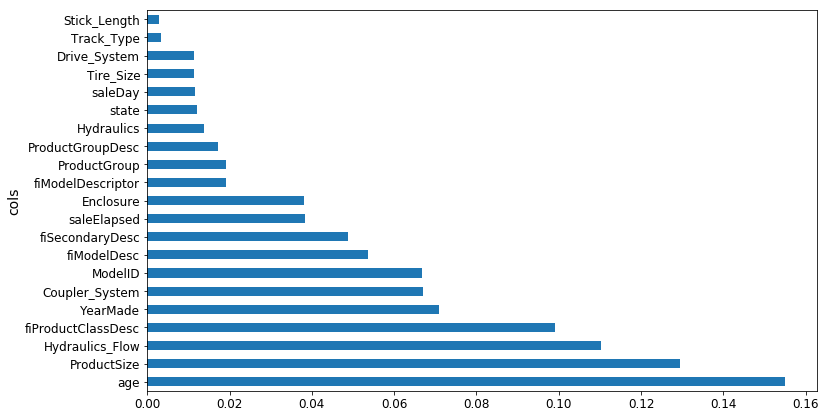

In [74]:
plot_fi(rf_feat_importance(m, X_train));

In [75]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [76]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 10min 53s, sys: 4.13 s, total: 10min 58s
Wall time: 1min 32s
[0.07993322647853363, 0.2107337117883635, 0.9866466721148694, 0.9206921808727907, 0.9145322926765902]
